In [30]:
import pandas as pd
from tqdm import tqdm
from sqlalchemy import create_engine, inspect

import numpy as np
import statsmodels.tsa.stattools as smt
from statsmodels.tsa.stattools import adfuller

tqdm.pandas(desc="Processing")

In [31]:
%reload_ext sql
%sql mysql://iasamori@localhost/?charset=utf8mb4
%config SqlMagic.displaylimit = 1000
%sql USE iasamori;

There's a new jupysql version available (0.11.1), you're running 0.10.9. To upgrade: pip install jupysql --upgrade
Deploy Shiny apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


Running query in 'mysql://iasamori@localhost/?charset=utf8mb4'

RuntimeError: (MySQLdb._exceptions.OperationalError) (2006, 'Server has gone away')
[SQL: USE iasamori;]
(Background on this error at: https://sqlalche.me/e/14/e3q8)
If you need help solving this issue, send us a message: https://ploomber.io/community


In [32]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [33]:
%%R

source("./psych290_data/helper_files/psych290RcodeV1.R")

require(tidyverse)
require(RSQLite)
require(ggthemes)
require(ggpubr)
require(grid)
require(reshape2)
require(psych)
require(lm.beta)
library(caret)

library(DBI)
library(RMySQL)

dbcon <- dbConnect(
  drv = MySQL(),
  host = "localhost",  # or your server address
  dbname = "iasamori",
  user = "iasamori",
  port = 3306
)

R[write to console]: Loading required package: RSQLite

R[write to console]: Loading required package: ggpubr

R[write to console]: Loading required package: lm.beta



In [6]:
def count_keywords(text, keyword_list):
    if pd.isna(text):
        return 0
    
    text = text.lower()
    
    count = 0
    for keyword in keyword_list:
        count += text.count(keyword.lower())

    return count

In [7]:
formal_terms = ["fentanyl", "opioid", "opiate", "morphine", "codeine", "oxycodone", "oxymorphone", "mscontin", "percocet"]
informal_terms = ["sublimaze", "duragesic", "fentanil", "sufentanil", "fentanylum", "fentora", "thebaine", "codiene", "roxanol", 
                  "kadian", "oxycontin", "roxicodone", "roxicet", "endocet", "endocodone", "oxyir", "oxynorm", "hydrocodone", "vicodin"]
keywords = formal_terms + informal_terms

In [8]:
len(keywords)

28

In [9]:
algospeak = ["f3nt", "0xy", "cod3in", "c0dein", "codi3n", "c0dien", "0pana"] 

In [10]:
video_df = pd.read_csv("./data/all_months_2_my.csv")
# video_df = video_df[["id", "create_time", "video_description"]]
video_df

,id,create_time,video_description,month_year
0,7063441153508805934,1644585553,#lossofachild #AlaskaAirCAREoke #fentanylaware...,2_2022
1,7063438031700905262,1644584826,codeine bad don’t do codeine,2_2022
2,7063399327305354542,1644575823,"You don’t know me, you just know what I post #...",2_2022
3,7063351253950008622,1644564622,There has been an 85% increase in fentanyl-rel...,2_2022
4,7063331793835068719,1644560090,#wedorecover #God #AlaskaAirCAREoke #jesus #So...,2_2022
...,...,...,...,...
97452,7207155741814312234,1678046723,#artblindbox #Survivor #agelikevampires so mu...,3_2023
97453,7207155173251140907,1678046616,Morning Tiktok i can say this filter is amazin...,3_2023
97454,7207151815496928558,1678045809,#PhysicalTrauma #PhysicalAssault #Opoidwithdra...,3_2023
97455,7207150205014199595,1678045431,BBJ not a day goes by that I don't miss you. E...,3_2023


In [11]:
a = pd.read_csv("./data/combined_comments_7.csv")
a["video_id"].nunique()

/tmp/ipykernel_1585460/2160108761.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  a = pd.read_csv("./data/combined_comments_7.csv")


48306

In [78]:
video_df["id"].nunique()

97457

In [83]:
comments_df = pd.read_csv("./data/combined_comments_7.csv")
comments_df = comments_df[["id", "create_time", "text"]]
comments_df

/tmp/ipykernel_1187040/2401868129.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  comments_df = pd.read_csv("./data/combined_comments_7.csv")


,id,create_time,text
0,7.298738e+18,1.699370e+09,how ya doing
1,7.305969e+18,1.701053e+09,Forever missing him
2,7.305974e+18,1.701055e+09,🥰🥰🥰
3,7.305974e+18,1.701055e+09,🥺🥺🥺
4,7.407155e+18,1.724613e+09,🙏🙏
...,...,...,...
938850,7.423118e+18,1.728329e+09,I take it to and it actually saved my life
938851,7.423090e+18,1.728323e+09,hey blessed Lil sister keep it up 💯
938852,7.423073e+18,1.728319e+09,Keep going. We do recover ❤️
938853,7.111869e+18,1.655861e+09,Does it need a good home ? I’m looking for a v...


In [44]:
comments_df["id"].nunique()

938854

In [45]:
for kw in keywords:
    video_df[kw] = video_df['video_description'].progress_apply(lambda x: count_keywords(x, [kw]))
    comments_df[kw] = comments_df['text'].progress_apply(lambda x: count_keywords(x, [kw]))

Processing: 100%|██████████| 938855/938855 [00:01<00:00, 904059.63it/s]


In [81]:
for kw in algospeak:
    video_df[kw] = video_df['video_description'].progress_apply(lambda x: count_keywords(x, [kw]))
    comments_df[kw] = comments_df['text'].progress_apply(lambda x: count_keywords(x, [kw]))

Processing: 100%|██████████| 938855/938855 [00:01<00:00, 897010.18it/s]


In [46]:
video_df.sample(5, random_state=23)

,id,create_time,video_description,month_year,fentanyl,opioid,opiate,morphine,codeine,oxycodone,...,kadian,oxycontin,roxicodone,roxicet,endocet,endocodone,oxyir,oxynorm,hydrocodone,vicodin
9586,7113941385018903854,1656343556,Trying to come down on the morphine so she can...,6_2022,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
59731,7384435063393488171,1719322784,I miss you so much Char bells .. I cant believ...,6_2024,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92016,7199501010300128555,1676264470,#griefjourney #llmy2🕊🕊 #longlivewoo🕊🕊🕊 #longli...,2_2023,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57166,7383886715003407659,1719195103,Life isnt easy without you too.. 💔 #fyp #fenta...,6_2024,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54550,7191887904283561259,1674491913,#Recovery #addict #addiction #addicted #Exaddi...,1_2023,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
comments_df.sample(5, random_state=23)

,id,create_time,text,fentanyl,opioid,opiate,morphine,codeine,oxycodone,oxymorphone,...,kadian,oxycontin,roxicodone,roxicet,endocet,endocodone,oxyir,oxynorm,hydrocodone,vicodin
106475,7.447324e+18,1.733965e+09,“are my eyes red yet?” ahh,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
546119,7.367459e+18,1.715370e+09,well… we all have opinions and i think that’s ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
207537,7.254814e+18,1.689143e+09,R.I.P 🕊,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
612452,7.183070e+18,1.672439e+09,Yes just not their drug of choiceor abuse. The...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
202525,7.245057e+18,1.686871e+09,How do people not see CPP have tried everythin...,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
vid_term_counts = dict(video_df[keywords].sum())

# vid_term_counts = dict(video_df[algospeak].sum())
vid_term_counts = dict(sorted(vid_term_counts.items(), key=lambda item: item[1], reverse=True))
vid_term_counts

{'fentanyl': 109873,
 'opioid': 22236,
 'opiate': 10211,
 'morphine': 6348,
 'codeine': 4684,
 'percocet': 3723,
 'fentanil': 1693,
 'kadian': 987,
 'oxycodone': 757,
 'codiene': 718,
 'oxycontin': 705,
 'vicodin': 464,
 'hydrocodone': 426,
 'oxyir': 19,
 'roxicodone': 18,
 'duragesic': 8,
 'oxymorphone': 6,
 'mscontin': 5,
 'roxicet': 5,
 'sublimaze': 4,
 'endocet': 3,
 'roxanol': 2,
 'fentora': 1,
 'thebaine': 1,
 'sufentanil': 0,
 'fentanylum': 0,
 'endocodone': 0,
 'oxynorm': 0}

In [49]:
comment_term_counts = dict(comments_df[keywords].sum())
# comment_term_counts = dict(comments_df[algospeak].sum())
comment_term_counts = {i:comment_term_counts[i] for i in list(vid_term_counts.keys())}
comment_term_counts

{'fentanyl': 21374,
 'opioid': 6177,
 'opiate': 3319,
 'morphine': 2642,
 'codeine': 312,
 'percocet': 914,
 'fentanil': 542,
 'kadian': 11,
 'oxycodone': 585,
 'codiene': 52,
 'oxycontin': 234,
 'vicodin': 177,
 'hydrocodone': 333,
 'oxyir': 0,
 'roxicodone': 31,
 'duragesic': 14,
 'oxymorphone': 12,
 'mscontin': 6,
 'roxicet': 8,
 'sublimaze': 3,
 'endocet': 0,
 'roxanol': 7,
 'fentora': 4,
 'thebaine': 7,
 'sufentanil': 3,
 'fentanylum': 0,
 'endocodone': 0,
 'oxynorm': 6}

In [50]:
vid_counts = list(vid_term_counts.values())
cmt_counts = list(comment_term_counts.values())
words = list(vid_term_counts.keys())

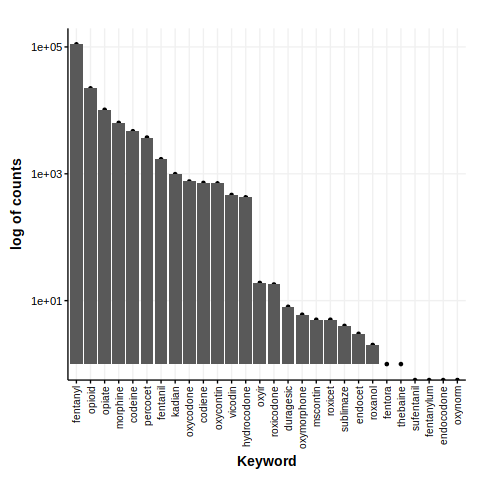

In [63]:
%%R -i vid_counts -i cmt_counts -i words

words <- factor(words, levels = unique(words))

p <- qplot(words, vid_counts) +
  geom_bar(stat = "identity") +
  theme_Publication() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, , size = 10)
    )+
  ylab("log of counts") + xlab("Keyword") +
  scale_y_log10()

ggsave("./figures/keyword_counts_video.svg", plot = p, width = 3.8, height = 3.5, dpi = 10000)
p

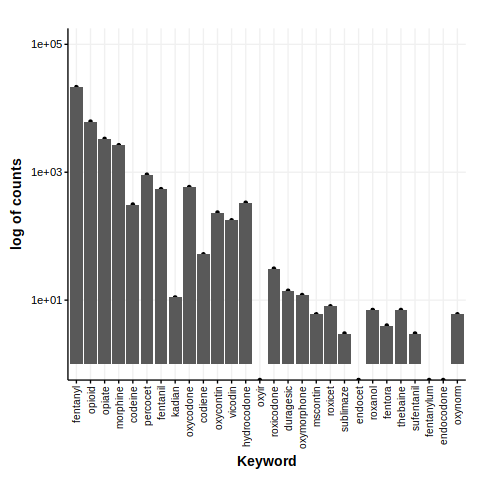

In [64]:
%%R -i vid_counts -i cmt_counts -i words

words <- factor(words, levels = unique(words))

p <- qplot(words, cmt_counts) +
  geom_bar(stat = "identity") +
  theme_Publication() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, , size = 10)
    )+
  ylab("log of counts") + xlab("Keyword") +
  scale_y_log10(limits = c(1, 1e5))
  

ggsave("./figures/keyword_counts_comments.svg", plot = p, width = 3.8, height = 3.5, dpi = 300)
p

In [19]:
%%R
meta_table <- dbGetQuery(dbcon, "select * from `feat$meta_1gram$cmt7_cln$message_id`")
meta_table_wide <- importFeat(meta_table)

print(mean(meta_table_wide$`_total1grams`))
print(sd(meta_table_wide$`_total1grams`))

[1] 19.50741
[1] 10.35389


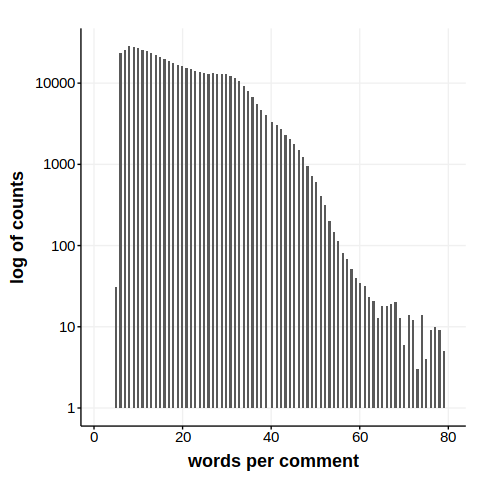

In [44]:
%%R

meta_table <- dbGetQuery(dbcon, "select * from `feat$meta_1gram$cmt7_cln$message_id`")
meta_table_wide <- importFeat(meta_table)
head(meta_table_wide)


p <- qplot(meta_table_wide$`_total1grams`, bins=160) +
        xlim(1,80) + scale_y_log10() +
        ylab("log of counts") + xlab("words per comment") +
        theme_Publication() +
        theme(
            axis.text.x = element_text(size = 15),
            axis.text.y = element_text(size = 15),
            axis.title.x = element_text(size = 18),
            axis.title.y = element_text(size = 18))


ggsave("./figures/num_words_dist.svg", plot = p, width = 3.5, height = 2.16, dpi = 300)
p

In [18]:
%%R -o cmt7

cmt7 <- dbGetQuery(dbcon, "select * from `cmt7_cln`")

cmt7$create_date <- as.Date(as.POSIXct(cmt7$create_time, origin = "1970-01-01"))
df_monthly <- cmt7 %>%
  count(month_year)

head(df_monthly)

  month_year     n
1    10_2021   650
2    10_2022 14871
3    10_2023  1164
4    10_2024 23233
5    11_2021   202
6    11_2022  3111


In [21]:
video_df

,id,create_time,video_description
0,7063441153508805934,1644585553,#lossofachild #AlaskaAirCAREoke #fentanylaware...
1,7063438031700905262,1644584826,codeine bad don’t do codeine
2,7063399327305354542,1644575823,"You don’t know me, you just know what I post #..."
3,7063351253950008622,1644564622,There has been an 85% increase in fentanyl-rel...
4,7063331793835068719,1644560090,#wedorecover #God #AlaskaAirCAREoke #jesus #So...
...,...,...,...
97452,7207155741814312234,1678046723,#artblindbox #Survivor #agelikevampires so mu...
97453,7207155173251140907,1678046616,Morning Tiktok i can say this filter is amazin...
97454,7207151815496928558,1678045809,#PhysicalTrauma #PhysicalAssault #Opoidwithdra...
97455,7207150205014199595,1678045431,BBJ not a day goes by that I don't miss you. E...


In [19]:
cmt7

,message,video_id,create_time,message_id,like_count,parent_comment_id,reply_count,month_year,create_date
1,I can sympathize with you. I am so sorry for y...,7.257209e+18,1.690165e+09,7.259202e+18,0.0,7.257209e+18,1,7_2023,19562.0
2,Thank you for your compassion many blessings t...,7.257209e+18,1.691675e+09,7.265687e+18,0.0,7.259202e+18,0,8_2023,19579.0
3,Another beautiful soul lost too soon. 💔🥺,7.210771e+18,1.679196e+09,7.212094e+18,2.0,7.210771e+18,0,3_2023,19435.0
4,"You are so welcome, what a beautiful boy you h...",7.210771e+18,1.678892e+09,7.210788e+18,1.0,7.210788e+18,0,3_2023,19431.0
5,This is absolutely beautiful tribute to my son...,7.210771e+18,1.678892e+09,7.210788e+18,1.0,7.210771e+18,2,3_2023,19431.0
...,...,...,...,...,...,...,...,...,...
569577,That’s exactly what I’m feeling now,7.111032e+18,1.694879e+09,7.279452e+18,0.0,7.111032e+18,0,9_2023,19616.0
569578,U.S. sees a sudden and unexpected drop in fata...,7.416088e+18,1.726693e+09,7.416091e+18,0.0,7.416088e+18,0,9_2024,19984.0
569579,Hey awesome! (6-4-22) We do recover!! ❤️,7.423049e+18,1.728331e+09,7.423126e+18,1.0,7.423049e+18,1,10_2024,20003.0
569580,I take it to and it actually saved my life,7.423049e+18,1.728329e+09,7.423118e+18,1.0,7.423049e+18,1,10_2024,20003.0


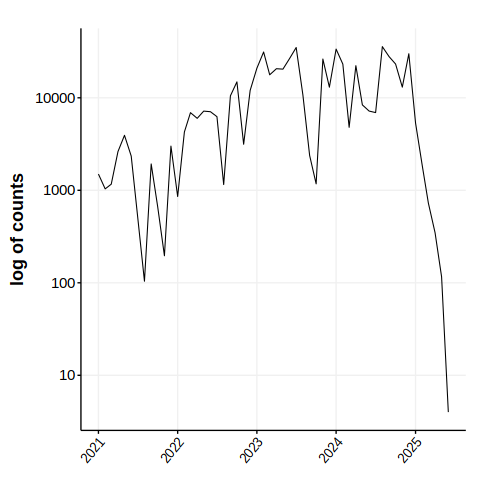

In [39]:
%%R

cmt7 <- dbGetQuery(dbcon, "select * from `cmt7_cln`")

cmt7$create_date <- as.Date(as.POSIXct(cmt7$create_time, origin = "1970-01-01"))

# Create a month-year column (as Date for plotting)
cmt7$month_year <- floor_date(cmt7$create_date, unit = "month")

# Count number of rows per month
df_monthly <- cmt7 %>%
  count(month_year)  # creates columns: month_year and n

p <- qplot(month_year, n, data = df_monthly, geom = "line") +
      theme_Publication() +
      ylab("log of counts") +
      xlab(NULL) +
      scale_y_log10() +
      scale_x_date(
        date_breaks = "1 year",
        date_labels = "%Y", 
        expand = c(0.05, 0.05)
      ) +
    theme(
                axis.text.x = element_text(angle = 50, hjust = 1, size = 13),
                axis.text.y = element_text(size = 15),
                axis.title.x = element_text(size = 18),
                axis.title.y = element_text(size = 18)
            
    ) 
# ggsave("./figures/time_dist.svg", plot = p, width = 3.5, height = 2.625, dpi = 300)
p

In [13]:
engine = create_engine(f"mysql://iasamori@localhost/iasamori?charset=utf8mb4")
cmt7_cln = pd.read_sql_query("SELECT * FROM cmt7_cln", engine)
engine.dispose()

In [14]:
idx_df = cmt7_cln[["message_id","create_time"]]
idx_df.to_csv("./data/ids_clean.csv", index=False)

In [15]:
comments_per_vid = cmt7_cln["video_id"].value_counts().values

In [16]:
comments_per_vid.mean(), comments_per_vid.std(), cmt7_cln["message_id"].nunique()

(15.042016584799029, 72.45081458682833, 569581)

In [ ]:
scale_y_log10(limits = c(10, 1e4))

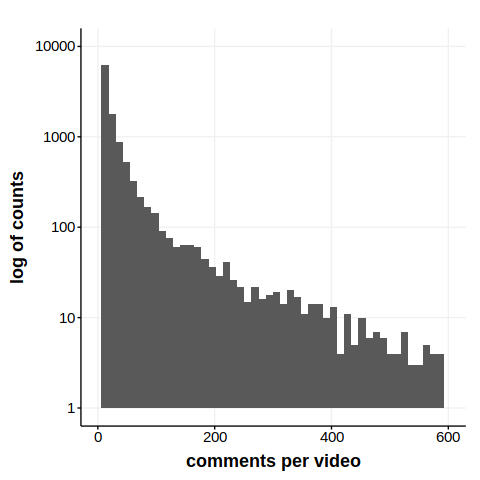

In [38]:
%%R -i comments_per_vid

p <- qplot(comments_per_vid, bins=50) +
        xlim(1,600) +
        ylab("log of counts") + xlab("comments per video") +
        theme_Publication() +
        scale_y_log10(limits = c(1, 1e4)) +
        theme(
            axis.text.x = element_text(size = 15),
            axis.text.y = element_text(size = 15),
            axis.title.x = element_text(size = 18),
            axis.title.y = element_text(size = 18)
        )

ggsave("./figures/comments_per_video_dist.svg", plot = p, width = 3.5, height = 2.16, dpi = 300)
p

In [78]:
%%R

cmt7_cln_lwic <- dbGetQuery(dbcon, "select * from `cmt7_cln_lwic`")

df_pronouns <- melt(cmt7_cln_lwic,
                   measure.vars = c("I", "YOU", "SHEHE"),
                   variable.name = "metric",
                   value.name = "value")

head(df_pronouns)

    message_id                                   message     video_id
1 6.912639e+18                Hi I really love your eyes 6.912577e+18
2 6.912664e+18 Hola btw I love your hair it's so cute 😁 6.912577e+18
3 6.912689e+18          hii 👋🏾😁 how was ur day today? 6.912577e+18
4 6.912689e+18      AAAHHHH your so pretty 🥺Heyyoooo 💙 6.912577e+18
5 6.912702e+18        Hiiii and you are sooooo beautiful 6.912577e+18
6 6.912731e+18         Ello shawty is that good or no 😏 6.912577e+18
  create_time like_count parent_comment_id reply_count month_year _intercept
1  1609474308          1      6.912577e+18           0    12_2020          1
2  1609479909          1      6.912577e+18           0     1_2021          1
3  1609485790          1      6.912577e+18           1     1_2021          1
4  1609485812          1      6.912577e+18           0     1_2021          1
5  1609488828          2      6.912577e+18           1     1_2021          1
6  1609495660          2      6.912577e+18           0 

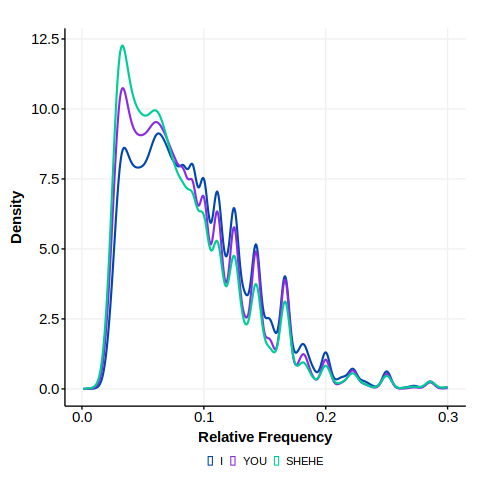

In [81]:
%%R

cmt7_cln_lwic <- dbGetQuery(dbcon, "select * from `cmt7_cln_lwic`")

# df_pronouns <- melt(cmt7_cln_lwic,
#                    measure.vars = c("I", "WE", "YOU", "SHEHE", "THEY"),
#                    variable.name = "metric",
#                    value.name = "value")

df_pronouns <- melt(cmt7_cln_lwic,
                   measure.vars = c("I", "YOU", "SHEHE"),
                   variable.name = "metric",
                   value.name = "value")

# Create a custom color mapping - same color for I/WE and for SHEHE/THEY
color_mapping <- c("I" = "#0047AB",      # Cobalt blue
                  "WE" = "#0047AB",      # Same cobalt blue
                  "YOU" = "#8A2BE2",     # Violet blue (purple)
                  "SHEHE" = "#00CC99",   # Caribbean green
                  "THEY" = "#00CC99")    # Same Caribbean green

# Create a custom line type mapping - solid for I and SHEHE, dashed for WE and THEY
line_mapping <- c("I" = "solid", 
                 "WE" = "dashed", 
                 "YOU" = "solid", 
                 "SHEHE" = "solid", 
                 "THEY" = "dashed")

p <- qplot(x = value, data = df_pronouns, geom = "density", color = metric, linetype = metric, 
            alpha = I(0), size = I(1)) + 
    theme_Publication() +
    scale_x_continuous(labels = scales::number_format(accuracy = 0.1), limits = c(0.001, 0.3)) +
    xlab("Relative Frequency") + ylab("Density") +
    scale_color_manual(values = color_mapping) +
    scale_linetype_manual(values = line_mapping) +
    # theme(legend.title = element_blank()) +
    theme(
        legend.title = element_blank(),
        axis.text.x = element_text(size = 15),
        axis.text.y = element_text(size = 15),
        axis.title.x = element_text(size = 15),
        axis.title.y = element_text(size = 15)
    )

ggsave("./figures/ppronoun_dist.svg", plot = p, width = 3.5, height = 2.5, dpi = 300)
p

In [90]:
ann_df = pd.read_csv("./data/combined_ann.csv")
ann_df = ann_df[ann_df["id"].isin(list(cmt7_cln["message_id"]))]

ann_df = ann_df.drop_duplicates(subset=["id"])
ann_df = ann_df.reset_index(drop=True)

ann_df["len"] = [len(i) for i in list(ann_df["annotation"])]
ann_df = ann_df[ann_df["len"] ==5]

ann_list = list(ann_df["annotation"])
ann_list = [i[1:-1] for i in ann_list]
ann_df["first"] = [int(i[0]) for i in ann_list]
ann_df["second"] = [int(i[1]) for i in ann_list]
ann_df["third"] = [int(i[2]) for i in ann_list]
ann_df

,id,annotation,explanation,time,len,first,second,third
0,7.252769e+18,'010',The comment directly addresses someone using '...,1.740936e+09,5,0,1,0
1,7.205662e+18,'101',The comment discusses both the speaker's own e...,1.740936e+09,5,1,0,1
2,7.296607e+18,'000',The comment does not contain a central drug-re...,1.740936e+09,5,0,0,0
3,7.407851e+18,'110',"The comment addresses 'you' and includes 'we',...",1.740936e+09,5,1,1,0
4,7.244576e+18,'001',The comment describes others' reluctance using...,1.740936e+09,5,0,0,1
...,...,...,...,...,...,...,...,...
355750,7.380389e+18,'000',The comment expresses a friendly message witho...,1.740778e+09,5,0,0,0
355751,7.204119e+18,'100',The comment reflects the speaker’s personal ex...,1.740778e+09,5,1,0,0
355752,7.304995e+18,'110',The comment combines a direct address to someo...,1.740778e+09,5,1,1,0
355753,7.257183e+18,'001',The comment primarily discusses others' drug u...,1.740778e+09,5,0,0,1


In [91]:
first = list(ann_df[ann_df["first"]==1]["id"])
second = list(ann_df[ann_df["second"]==1]["id"])
third = list(ann_df[ann_df["third"]==1]["id"])
len(first), len(second), len(third)

(140755, 109231, 109785)

In [92]:
len(ann_df[ann_df["annotation"]=="'000'"])

50815

In [93]:
persp_ids = list((set(first + second + third)))
complement = list(ann_df[~ann_df["id"].isin(persp_ids)]["id"])
len(persp_ids), len(complement), len(ann_df)

(304937, 50815, 355752)

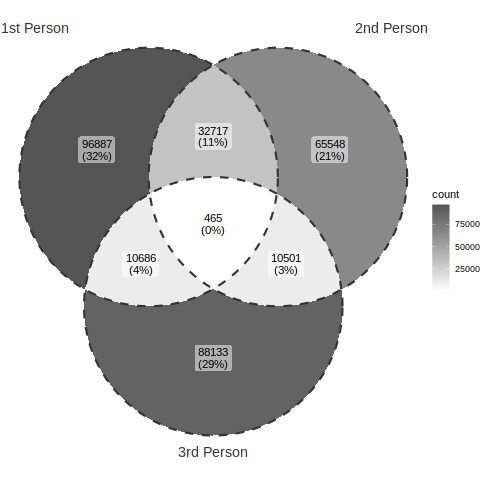

In [262]:
%%R -i first -i second -i third -i complement

library(ggplot2)
library(ggVennDiagram)

# Install if needed
# install.packages("ggVennDiagram")

library(ggVennDiagram)
library(ggplot2)

# Example data - list of sets
set_list <- list(
    first_person = first,
    second_person = second,
    third_person = third
)

p <- ggVennDiagram(set_list, 
                category.names = c("1st Person", "2nd Person", "3rd Person"),
                set_label_pos = c(0.1, 0.1, 0.5),
                edge_lty = "dashed",
                set_color = c("#333333", "#333333", "#333333"),
                label_alpha = 0.5,   # Background transparency for labels
                label_size = 4,      # Adjust text size
                set_size = 5, 
                text_color = "#FF6600", set_text_color = "#FF6600") +      # Adjust category label size
  # Use custom grayscale fill colors
  scale_fill_gradient(low = "#FFFFFF", high = "#555555")

print(p)

# Save the plot (optional)
ggsave("./figures/venn_diagram.svg", plot = p, width = 3.5, height = 3.5, dpi = 300)


In [29]:
precision = [1, 0.82, 1]
recall = [1, 1, 0.77]
labels = ["1st Person", "2nd Person", "3rd Person"]


In [ ]:
precision = [0.84, 0.89, 1.0, 0.91]
recall = [1, 0.89, 0.79, 0.88]
labels = ["1st Person", "2nd Person", "3rd Person", "Overall"]


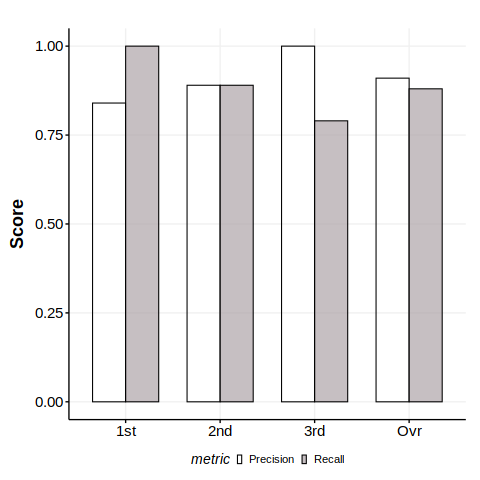

In [42]:
%%R -i precision -i recall -i labels

# Load library
library(ggplot2)
# library(ggpattern)

# Create data frame
data <- data.frame(
  metric = rep(c("Precision", "Recall"), each = 4),
  person = rep(c("1st", "2nd", "3rd", "Ovr"), 2),
  value = c(0.84, 0.89, 1.0, 0.91, 1, 0.89, 0.79, 0.88 )
  # value = c(1, 0.82, 1, 1, 1, 0.77)
    
)

# Create a plot with different fill and alpha settings
p <- ggplot(data, aes(x = person, y = value, fill = metric)) +
  geom_col(position = position_dodge(width = 0.7), 
           width = 0.7,
           color = "black",  # All bars get black outline
           aes(alpha = metric)) +  # Different transparency
  scale_fill_manual(values = c("Precision" = "white", "Recall" = "#AEA3A7")) +
  scale_alpha_manual(values = c("Precision" = 0, "Recall" = 0.7)) +
  theme_minimal() +
  labs(x = NULL, y = "Score") +
  theme_Publication() +
  theme(
       panel.grid = element_blank(),
       axis.text.x = element_text(size = 15),
       axis.text.y = element_text(size = 15),
       axis.title.x = element_text(size = 18),
       axis.title.y = element_text(size = 18))+
  # Combine the legends
  guides(fill = guide_legend(override.aes = list(alpha = c(0, 0.7))),
         alpha = FALSE)  # Hide the alpha legend

ggsave("./figures/precision_recall.svg", plot = p, width = 3.5, height = 2.16, dpi = 300)
p

In [24]:
keyword_norm_df = pd.read_csv("./data/tt_norm_values.csv")
cdc_norm_df = pd.read_csv("./data/death_census_merge.csv")
topic_norm_df = pd.read_csv("./data/topic_norms.csv")
covid_norm_df = pd.read_csv("./data/covid_census_merge.csv")

topic_number = "196"
years = [2023, 2024]

In [25]:
cdc_norm_df = cdc_norm_df[cdc_norm_df["Year"].isin(years)]
topic_norm_df = topic_norm_df[topic_norm_df["year"].isin(years)]
covid_norm_df = covid_norm_df[covid_norm_df["year"].isin(years)]

In [26]:
%%R -i cdc_norm_df

cdc_norm_df$date <- as.Date(paste(cdc_norm_df$year, cdc_norm_df$month_num, "01", sep="-"))
cdc_norm_df$month_year <- format(cdc_norm_df$date, "%b %Y")
cdc_norm_df$month_year <- factor(cdc_norm_df$month_year, 
                                 levels = unique(cdc_norm_df$month_year[order(cdc_norm_df$date)]))

/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [99]:
%%R 
head(cdc_norm_df$date)

[1] "2023-01-01" "2023-02-01" "2023-03-01" "2023-04-01" "2023-05-01"
[6] "2023-06-01"


[1] "synthetic_norm"


/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


[1] "nat_semi_norm"


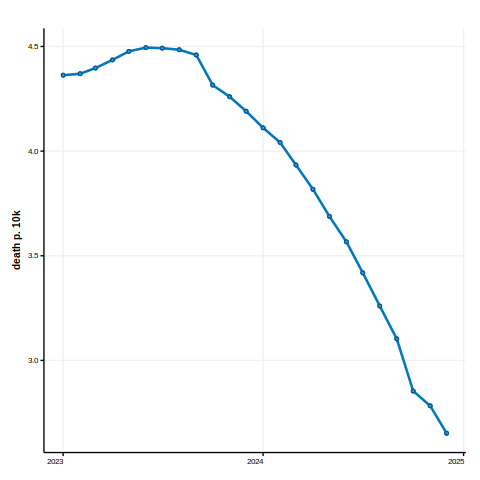

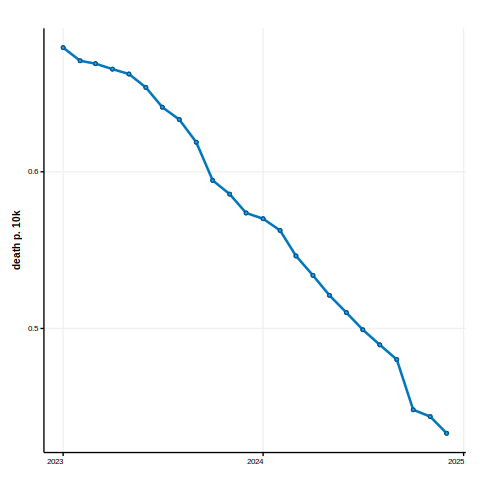

In [173]:
%%R -i cdc_norm_df

cdc_norm_df$date <- as.Date(paste(cdc_norm_df$year, cdc_norm_df$month_num, "01", sep="-"))
cdc_norm_df$month_year <- format(cdc_norm_df$date, "%b %Y")
cdc_norm_df$month_year <- factor(cdc_norm_df$month_year, 
                                 levels = unique(cdc_norm_df$month_year[order(cdc_norm_df$date)]))

columns_to_plot <- c("synthetic_norm", "nat_semi_norm")

# Loop through each column
for (col in columns_to_plot) {

    cdc_norm_df[[col]] <- cdc_norm_df[[col]] * 10000

    # Create the plot
    p <- qplot(x = date, y = .data[[col]], data = cdc_norm_df, group = 1, ylab = "death p. 10k") +
        theme_Publication() +
        scale_y_continuous(labels = scales::number_format(accuracy = 0.1)) +
        scale_x_date(date_breaks = "1 year", date_labels = "%Y", expand = c(0.05, 0.05)) +
        theme(
            axis.text.x = element_text(angle = 0, hjust = 1, size = 8),
            axis.text.y = element_text(size = 8),
            axis.title.x = element_text(size = 10),
            axis.title.y = element_text(size = 10)
        ) +

        # theme(axis.text.x = element_text(angle = 45, hjust = 1), 
        #     plot.margin = margin(t = 10, r = 25, b = 40, l = 10, unit = "pt")) +
        xlab(NULL) +
        geom_line(color = "#0077be", size = 1.2) +  # Strong blue line 
        geom_point(color = "#005a9c", fill = "#39a5dc", shape = 21, size = 1, stroke = 1) # Blue outline with lighter blue fill

    ggsave(paste0("./figures/cdc_", col, ".svg"), plot = p, width = 3.5, height = 1.5, dpi = 300)

    print(col)
    print(p)
    # break
}


[1] "methadone_norm"


/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


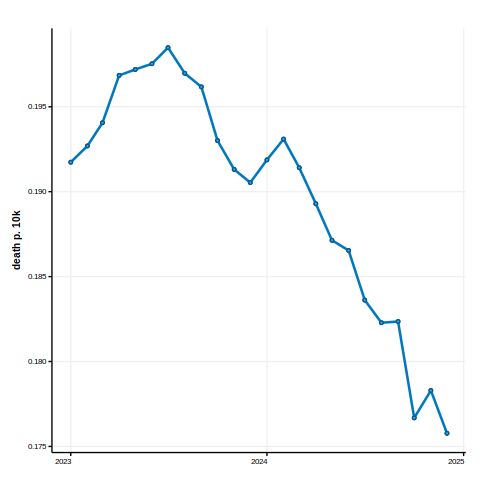

In [10]:
%%R -i cdc_norm_df

cdc_norm_df$date <- as.Date(paste(cdc_norm_df$year, cdc_norm_df$month_num, "01", sep="-"))
cdc_norm_df$month_year <- format(cdc_norm_df$date, "%b %Y")
cdc_norm_df$month_year <- factor(cdc_norm_df$month_year, 
                                 levels = unique(cdc_norm_df$month_year[order(cdc_norm_df$date)]))

columns_to_plot <- c("methadone_norm")

# Loop through each column
for (col in columns_to_plot) {

    cdc_norm_df[[col]] <- cdc_norm_df[[col]] * 10000

    # Create the plot
    p <- qplot(x = date, y = .data[[col]], data = cdc_norm_df, group = 1, ylab = "death p. 10k") +
        theme_Publication() +
        scale_y_continuous(labels = scales::number_format(accuracy = 0.001)) +
        scale_x_date(date_breaks = "1 year", date_labels = "%Y", expand = c(0.05, 0.05)) +
        theme(
            axis.text.x = element_text(angle = 0, hjust = 1, size = 8),
            axis.text.y = element_text(size = 8),
            axis.title.x = element_text(size = 10),
            axis.title.y = element_text(size = 10)
        ) +

        # theme(axis.text.x = element_text(angle = 45, hjust = 1), 
        #     plot.margin = margin(t = 10, r = 25, b = 40, l = 10, unit = "pt")) +
        xlab(NULL) +
        geom_line(color = "#0077be", size = 1.2) +  # Strong blue line 
        geom_point(color = "#005a9c", fill = "#39a5dc", shape = 21, size = 1, stroke = 1) # Blue outline with lighter blue fill

    # ggsave(paste0("./figures/cdc_", col, ".svg"), plot = p, width = 3.5, height = 1.5, dpi = 300)

    print(col)
    print(p)
    # break
}

[1] "covid_norm"


/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


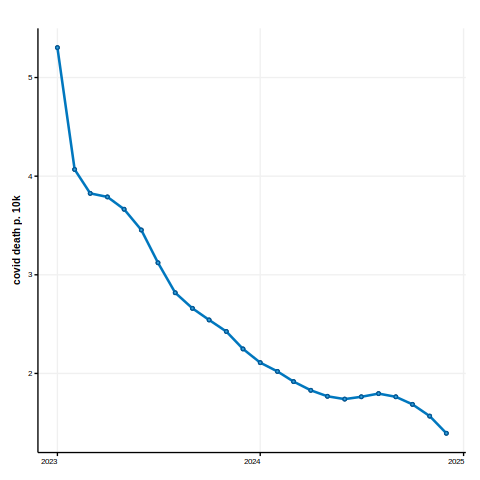

In [29]:
%%R -i covid_norm_df

# head(covid_norm_df)
covid_norm_df$date <- as.Date(paste(covid_norm_df$year, covid_norm_df$month_num, "01", sep="-"))
covid_norm_df$month_year <- format(covid_norm_df$date, "%b %Y")
covid_norm_df$month_year <- factor(covid_norm_df$month_year, 
                                 levels = unique(covid_norm_df$month_year[order(covid_norm_df$date)]))

columns_to_plot <- c("covid_norm")

# Loop through each column
for (col in columns_to_plot) {

    covid_norm_df[[col]] <- covid_norm_df[[col]] * 10000

    # Create the plot
    p <- qplot(x = date, y = .data[[col]], data = covid_norm_df, group = 1, ylab = "covid death p. 10k") +
        theme_Publication() +
        scale_x_date(date_breaks = "1 year", date_labels = "%Y", expand = c(0.05, 0.05)) +
        theme(
            axis.text.x = element_text(angle = 0, hjust = 1, size = 8),
            axis.text.y = element_text(size = 8),
            axis.title.x = element_text(size = 10),
            axis.title.y = element_text(size = 10)
        ) +
        xlab(NULL) +
        geom_line(color = "#0077be", size = 1.2) +  # Strong blue line 
        geom_point(color = "#005a9c", fill = "#39a5dc", shape = 21, size = 1, stroke = 1) # Blue outline with lighter blue fill

    ggsave(paste0("./figures/cdc_", col, ".svg"), plot = p, width = 3.5, height = 1.5, dpi = 300)

    print(col)
    print(p)
    # break
}


In [ ]:
%%R -i topic_norm_df

topic_norm_df$date <- as.Date(paste(topic_norm_df$year, topic_norm_df$month, "01", sep="-"))
topic_norm_df$month_year <- format(topic_norm_df$date, "%b %Y")
topic_norm_df$month_year <- factor(topic_norm_df$month_year, 
                                 levels = unique(topic_norm_df$month_year[order(topic_norm_df$date)]))

columns_to_plot <- c("196_norm")

# Loop through each column
for (col in columns_to_plot) {

    topic_norm_df[[col]] <- topic_norm_df[[col]] * 10000

    # Create the plot
    p <- qplot(x = date, y = .data[[col]], data = topic_norm_df, group = 1, ylab = "TT Score p. 10k") +
        theme_Publication() +
        scale_x_date(date_breaks = "1 year", date_labels = "%Y", expand = c(0.05, 0.05)) +
        theme(
            axis.text.x = element_text(angle = 0, hjust = 1, size = 8),
            axis.text.y = element_text(size = 8),
            axis.title.x = element_text(size = 10),
            axis.title.y = element_text(size = 10)
        ) +
        xlab(NULL) +
        geom_line(color = "#e67e22", size = 1.2) + 
        geom_point(color = "#d35400", fill = "#f39c12", shape = 21, size = 1, stroke = 1)

    ggsave(paste0("./figures/topic_", col, ".svg"), plot = p, width = 3.5, height = 1.5, dpi = 300)

    print(col)
    print(p)
    # break
}

In [20]:
%%R

plot_correlation <- function(trend, detrend, lags) {
  # Convert lags to factor with proper levels
  lags <- factor(lags, levels = unique(lags))
  
  # Create a data frame for your original points
  trend_data <- data.frame(lags = lags, value = trend, type = "Trend")
  detrend_data <- data.frame(lags = lags, value = detrend, type = "Detrend")
  
  # Combine the data
  combined_data <- rbind(trend_data, detrend_data)
  
  # Create the plot with different shapes based on type
  p <- ggplot(combined_data, aes(x = lags, y = value, shape = type)) +
    geom_point(size = 3) +  # Larger points
    scale_shape_manual(values = c(Trend = 16, Detrend = 4)) +  # 16 = dot, 4 = X
    theme_Publication() +
    xlab("Lag Offset (months)") +
    ylab("Cross Correlation") +
    ylim(-1,1) +
    theme(
      axis.text = element_text(size = 14),
      axis.title = element_text(size = 16),
      plot.title = element_text(size = 18),
      legend.text = element_text(size = 12),
      legend.title = element_blank(),  # Remove the legend title
      legend.position = "top"          # Position the legend at the bottom
    )
  
  return(p)
}

In [9]:
keyword_norm_df = pd.read_csv("./data/tt_norm_values.csv")
cdc_norm_df = pd.read_csv("./data/death_census_merge.csv")
topic_norm_df = pd.read_csv("./data/topic_norms.csv")

topic_number = "196"
years = [2023, 2024]

cdc_norm_df = cdc_norm_df[cdc_norm_df["Year"].isin(years)]
topic_norm_df = topic_norm_df[topic_norm_df["year"].isin(years)]
lags = [str(i) for i in list(range(-6, 7))]

cdc_norm_df.shape, topic_norm_df.shape

((24, 20), (24, 404))

In [176]:
nsn_mean, nsn_trend, nsn_detrend = cum_r(topic_norm_df[f"{196}_norm"], cdc_norm_df["nat_semi_norm"])
lags = [str(i) for i in list(range(-6, 7))]
print(nsn_trend)
print(nsn_detrend)

[-0.05222713  0.05606686  0.18010199  0.32597595  0.47313007  0.63844073
  0.78016098  0.79200818  0.77831554  0.71241806  0.66269658  0.59247261
  0.51300032]
[ 0.04918515  0.08226902 -0.04238082 -0.01432047  0.25420743  0.29032744
  0.41735591  0.21869022 -0.20502304  0.05197189  0.15256671  0.18188488
  0.14437779]


/tmp/ipykernel_820650/1950640806.py:23: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  backwards = smt.ccf(y, x, unbiased=False, nlags = lag_max + 1)[::-1]
/tmp/ipykernel_820650/1950640806.py:24: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  forwards = smt.ccf(x, y, unbiased=False, nlags = lag_max + 1)


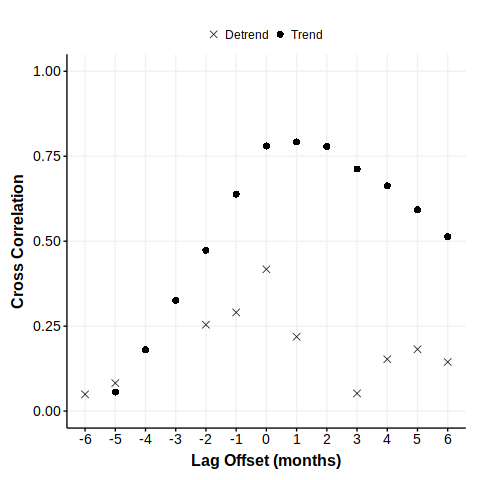

In [177]:
%%R -i nsn_trend -i nsn_detrend -i lags

p <- plot_correlation(nsn_trend, nsn_detrend, lags)
ggsave("./figures/r_nat_semi_norm_tpc196.svg", plot = p, width = 3.5, height = 3.5, dpi = 300) 
p

In [178]:
met_mean, met_trend, met_detrend = cum_r(topic_norm_df[f"{196}_norm"], cdc_norm_df["methadone_norm"])
lags = [str(i) for i in list(range(-6, 7))]
print(met_trend)
print(met_detrend)

[0.06752848 0.19552681 0.33757216 0.49049366 0.65017914 0.81656347
 0.91877625 0.82966469 0.73572267 0.60338656 0.52718189 0.41494529
 0.28633424]
[ 0.0936268   0.1002      0.16113729  0.04317318  0.31658548  0.57562803
  0.27127823  0.24880359 -0.02048734  0.01425539  0.23843741  0.23568238
  0.06848848]


/tmp/ipykernel_820650/1950640806.py:23: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  backwards = smt.ccf(y, x, unbiased=False, nlags = lag_max + 1)[::-1]
/tmp/ipykernel_820650/1950640806.py:24: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  forwards = smt.ccf(x, y, unbiased=False, nlags = lag_max + 1)


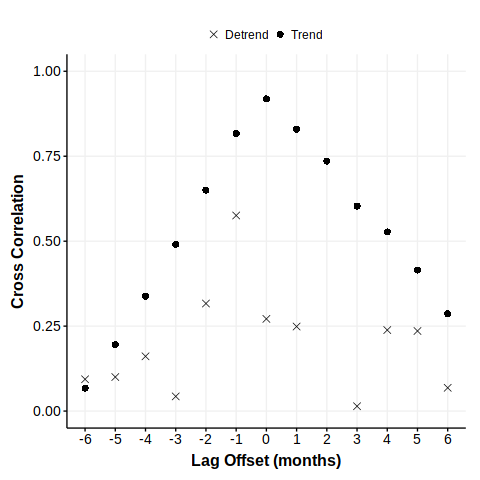

In [179]:
%%R -i met_trend -i met_detrend -i lags

p <- plot_correlation(met_trend, met_detrend, lags)
ggsave("./figures/r_methadone_tpc196.svg", plot = p, width = 3.5, height = 3.5, dpi = 300) 
p

In [11]:
syn_mean, syn_trend, syn_detrend = cum_r(topic_norm_df[f"{196}_norm"], cdc_norm_df["synthetic_norm"])
lags = [str(i) for i in list(range(-6, 7))]
print(syn_trend)
print(syn_detrend)

[0.07937918 0.20864647 0.34988498 0.50385357 0.64441948 0.79913326
 0.91774475 0.85261271 0.76755755 0.64640722 0.53711707 0.4216821
 0.30888158]
[0.31882644 0.30182499 0.35792507 0.43084258 0.46504278 0.53989491
 0.5816319  0.42110761 0.16035015 0.2038015  0.19893245 0.15598977
 0.06878909]


/tmp/ipykernel_873912/1950640806.py:23: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  backwards = smt.ccf(y, x, unbiased=False, nlags = lag_max + 1)[::-1]
/tmp/ipykernel_873912/1950640806.py:24: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  forwards = smt.ccf(x, y, unbiased=False, nlags = lag_max + 1)


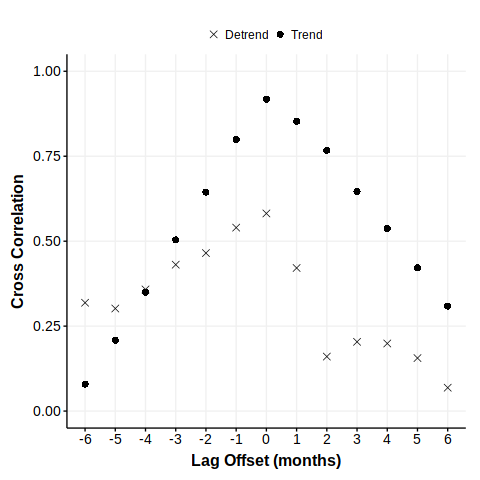

In [12]:
%%R -i syn_trend -i syn_detrend -i lags

p <- plot_correlation(syn_trend, syn_detrend, lags)
ggsave("./figures/r_synthetic_tpc196.svg", plot = p, width = 3.5, height = 3.5, dpi = 300) 
p

In [23]:
reocvery_mean, recovery_trend, recovery_detrend = cum_r(topic_norm_df[f"{192}_norm"], cdc_norm_df["methadone_norm"])
lags = [str(i) for i in list(range(-6, 7))]
print(recovery_trend)
print(recovery_detrend)

[-0.08549926 -0.24065944 -0.37745493 -0.47546877 -0.56420621 -0.62555943
 -0.77975434 -0.73359344 -0.7195522  -0.60377043 -0.50669412 -0.38369294
 -0.24938967]
[-0.17715374 -0.0007275   0.00937111 -0.15553508 -0.08682411 -0.12654073
 -0.33566286  0.0955096  -0.55665271 -0.31226291 -0.14225765 -0.03830711
  0.13366074]


/tmp/ipykernel_873912/1950640806.py:23: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  backwards = smt.ccf(y, x, unbiased=False, nlags = lag_max + 1)[::-1]
/tmp/ipykernel_873912/1950640806.py:24: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  forwards = smt.ccf(x, y, unbiased=False, nlags = lag_max + 1)


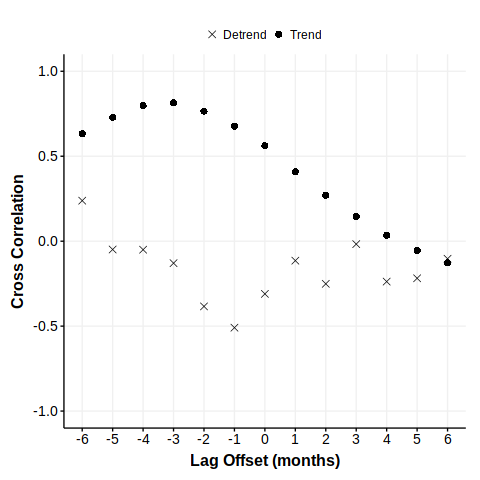

In [22]:
%%R -i recovery_trend -i recovery_detrend -i lags

p <- plot_correlation(recovery_trend, recovery_detrend, lags)
ggsave("./figures/use_comp.svg", plot = p, width = 3.5, height = 3.5, dpi = 300) 
p

In [184]:
from statsmodels.tsa.stattools import adfuller

col = "nat_semi_norm"
ts = cdc_norm_df[col].diff().dropna()
adf_result = adfuller(ts)

print(f"***** {col} *****")
print(f"ADF Statistic: {adf_result[0]}")
print(f"ADF p-value: {adf_result[1]}")

***** nat_semi_norm *****
ADF Statistic: -4.4681244520091745
ADF p-value: 0.0002244299287781201


In [185]:
from statsmodels.tsa.stattools import adfuller

col = "methadone_norm"
ts = cdc_norm_df[col].diff().dropna()
adf_result = adfuller(ts)

print(f"***** {col} *****")
print(f"ADF Statistic: {adf_result[0]}")
print(f"ADF p-value: {adf_result[1]}")

***** methadone_norm *****
ADF Statistic: -4.18156086787091
ADF p-value: 0.0007078893321342256


In [186]:
from statsmodels.tsa.stattools import adfuller

col = "synthetic_norm"
ts = cdc_norm_df[col].diff().dropna()
adf_result = adfuller(ts)

print(f"***** {col} *****")
print(f"ADF Statistic: {adf_result[0]}")
print(f"ADF p-value: {adf_result[1]}")

***** synthetic_norm *****
ADF Statistic: -1.8973858325506525
ADF p-value: 0.3332918952358861


In [187]:
from statsmodels.tsa.stattools import adfuller

col = "Topic 196"
ts = topic_norm_df[f"{196}_norm"].diff().dropna()
adf_result = adfuller(ts)

print(f"***** {col} *****")
print(f"ADF Statistic: {adf_result[0]}")
print(f"ADF p-value: {adf_result[1]}")

***** Topic 196 *****
ADF Statistic: -3.646535828193637
ADF p-value: 0.004931210985487576


In [124]:
tpc178 = cum_r(topic_norm_df[f"{178}_norm"], cdc_norm_df["methadone_norm"])
tpc192 = cum_r(topic_norm_df[f"{192}_norm"], cdc_norm_df["methadone_norm"])
tpc196 = cum_r(topic_norm_df[f"{196}_norm"], cdc_norm_df["methadone_norm"])

/tmp/ipykernel_943827/1950640806.py:23: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  backwards = smt.ccf(y, x, unbiased=False, nlags = lag_max + 1)[::-1]
/tmp/ipykernel_943827/1950640806.py:24: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  forwards = smt.ccf(x, y, unbiased=False, nlags = lag_max + 1)


In [176]:
results = [tpc178, tpc192, tpc196]

r_trend_list = []
r_detrend_list = []
for corr in results:
    id = corr[0].argmax()
    r_trend_list.append(corr[1][id])
    r_detrend_list.append(corr[2][id])

heatmap_df = pd.DataFrame()
heatmap_df["data_type"] = ["r_trend"]*3 + ["r_detrend"]*3 
heatmap_df["topic"] = ["Topic 178", "Topic 192", "Topic 196"]*2 
heatmap_df["value"] = r_trend_list + r_detrend_list

heatmap_df

,data_type,topic,value
0,r_trend,Topic 178,0.632082
1,r_trend,Topic 192,-0.249390
2,r_trend,Topic 196,0.816563
3,r_detrend,Topic 178,0.238460
4,r_detrend,Topic 192,0.133661
5,r_detrend,Topic 196,0.575628


/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


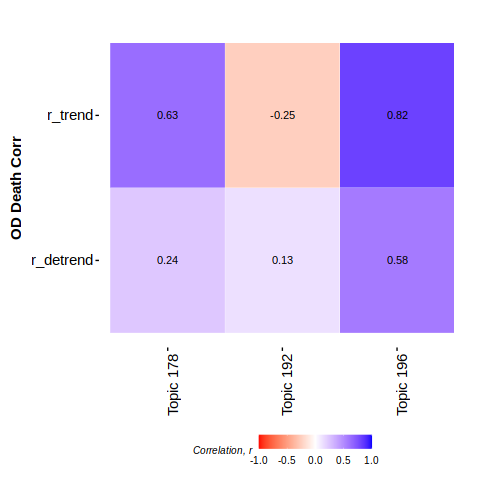

In [211]:
%%R -i heatmap_df

library(ggplot2)
library(viridis)

p <- ggplot(heatmap_df, aes(x = topic, y = data_type, fill = value)) +
  geom_tile(color = "white") +
  geom_text(aes(label = round(value, 2)), color = "black") +
  scale_fill_gradient2(low = "red", mid = "white", high = "blue", 
                       midpoint = 0, limits = c(-1, 1)) +  # Using viridis color palette
  labs(x = "Topic",
       y = "OD Death Corr",
       fill = "Correlation, r") +
  theme_Publication() +
  theme(
    axis.line = element_blank(),
    axis.title.x = element_blank(),
    axis.title.y = element_text(size = 15),
    axis.text.x = element_text(angle = 90, hjust = 1, size = 15),
    axis.text.y = element_text(size = 15),
    panel.grid.major = element_blank(),
    legend.position = "bottom", legend.direction = "horizontal",
    legend.key.width = unit(0.8, "cm"),
    legend.key.height = unit(0.5, "cm"),
    legend.margin = margin(t = 5),
    legend.text = element_text(size = 10, angle = 0),
    legend.title = element_text(size = 10, angle = 0))

ggsave("./figures/heatmap_topic.svg", plot = p, width = 3.5, height = 3.5, dpi = 300) 

p

In [212]:
opioid = cum_r(topic_norm_df[f"{196}_norm"], cdc_norm_df["methadone_norm"])
covid = cum_r(topic_norm_df[f"{196}_norm"], covid_norm_df["covid_norm"])

results = [covid, opioid]

r_trend_list = []
r_detrend_list = []
for corr in results:
    id = corr[0].argmax()
    r_trend_list.append(corr[1][id])
    r_detrend_list.append(corr[2][id])

heatmap_df2 = pd.DataFrame()
heatmap_df2["data_type"] = ["r_trend"]*2 + ["r_detrend"]*2
heatmap_df2["outcome"] = ["covid", "opioid"]*2 
heatmap_df2["value"] = r_trend_list + r_detrend_list

heatmap_df2

/tmp/ipykernel_943827/1950640806.py:23: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  backwards = smt.ccf(y, x, unbiased=False, nlags = lag_max + 1)[::-1]
/tmp/ipykernel_943827/1950640806.py:24: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  forwards = smt.ccf(x, y, unbiased=False, nlags = lag_max + 1)


,data_type,outcome,value
0,r_trend,covid,0.682601
1,r_trend,opioid,0.816563
2,r_detrend,covid,-0.105051
3,r_detrend,opioid,0.575628


/opt/miniconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


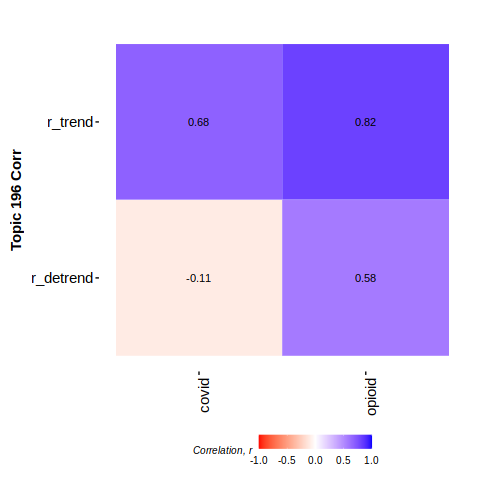

In [213]:
%%R -i heatmap_df2

library(ggplot2)
library(viridis)


p <- ggplot(heatmap_df2, aes(x = outcome, y = data_type, fill = value)) +
  geom_tile(color = "white") +
  geom_text(aes(label = round(value, 2)), color = "black") +
  scale_fill_gradient2(low = "red", mid = "white", high = "blue", 
                       midpoint = 0, limits = c(-1, 1)) +  # Using viridis color palette
  labs(x = "Topic",
       y = "Topic 196 Corr",
       fill = "Correlation, r") +
  theme_Publication() +
  theme(
    axis.line = element_blank(),
    axis.title.x = element_blank(),
    axis.title.y = element_text(size = 15),
    axis.text.x = element_text(angle = 90, hjust = 1, size = 15),
    axis.text.y = element_text(size = 15),
    panel.grid.major = element_blank(),
    legend.position = "bottom", legend.direction = "horizontal",
    legend.key.width = unit(0.8, "cm"),
    legend.key.height = unit(0.5, "cm"),
    legend.margin = margin(t = 5),
    legend.text = element_text(size = 10, angle = 0),
    legend.title = element_text(size = 10, angle = 0))

ggsave("./figures/heatmap_outcome.svg", plot = p, width = 3.5, height = 3.5, dpi = 300) 

p

In [241]:
trend

array([0.07287685, 0.20152692, 0.34223432, 0.49602933, 0.63717594,
       0.7926303 , 0.91252294, 0.8510492 , 0.76930683, 0.65022845,
       0.5442648 , 0.43107154, 0.31964244])

In [242]:
detrend

array([0.30706759, 0.29915522, 0.34779523, 0.41483047, 0.46045092,
       0.53066921, 0.57307568, 0.41628569, 0.13999752, 0.19465311,
       0.19728255, 0.16171048, 0.0722744 ])

In [126]:
!pip install --upgrade statsmodels


Defaulting to user installation because normal site-packages is not writeable


In [232]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Assuming 'deaths' and 'signal' are your time series
data = np.column_stack([cdc_norm_df["opioid_norm"], topic_norm_df[f"{196}_norm"]])

# Test for cointegration
result = coint_johansen(data, det_order=0, k_ar_diff=1)

# Check test statistics against critical values
print(result.lr1)  # Test statistics
print(result.cvt)  # Critical values


[17.29480278  3.27115595]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


In [233]:
import statsmodels.api as sm

# Assuming 'deaths' and 'signal' are your time series
X = sm.add_constant(topic_norm_df[f"{196}_norm"].values)  # Add constant term
cointegrating_model = sm.OLS(cdc_norm_df["opioid_norm"].values, X).fit()

# Extract residuals (equilibrium errors)
eq_errors = cointegrating_model.resid

In [236]:
deaths = cdc_norm_df["opioid_norm"].reset_index(drop=True)
signal = topic_norm_df[f"{196}_norm"].reset_index(drop=True)

In [237]:
# Create first differences
deaths_diff = deaths.diff().dropna()
signal_diff = signal.diff().dropna()

# To ensure proper alignment, let's create a DataFrame with everything
data = pd.DataFrame({
    'deaths': deaths,
    'signal': signal,
    'eq_errors': eq_errors
})

# Add differences
data['deaths_diff'] = data['deaths'].diff()
data['signal_diff'] = data['signal'].diff()

# Add lags
data['eq_errors_lag'] = data['eq_errors'].shift(1)
data['deaths_diff_lag'] = data['deaths_diff'].shift(1)
data['signal_diff_lag'] = data['signal_diff'].shift(1)

# Remove rows with NAs (first two rows will have NAs due to differencing and lagging)
data_clean = data.dropna()

In [239]:
# Enhanced ECM with lags
Y = data_clean['deaths_diff']
X = sm.add_constant(data_clean[['signal_diff', 'signal_diff_lag', 
                               'deaths_diff_lag', 'eq_errors_lag']])

enhanced_ecm = sm.OLS(Y, X).fit()
print(enhanced_ecm.summary())

                            OLS Regression Results                            
Dep. Variable:            deaths_diff   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     5.473
Date:                Sat, 07 Jun 2025   Prob (F-statistic):            0.00510
Time:                        04:58:12   Log-Likelihood:                 237.46
No. Observations:                  22   AIC:                            -464.9
Df Residuals:                      17   BIC:                            -459.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -4.534e-06    1.9e-06     

In [198]:
eq_errors

array([ 7.86311820e-05,  5.87217394e-05,  1.48775736e-05,  1.77758055e-05,
        1.11877291e-05,  1.35432168e-05,  1.39546004e-05, -2.96737392e-06,
       -2.04871099e-05,  6.41329738e-06, -9.75025196e-06, -3.15106180e-05,
       -4.17144231e-05, -2.72677972e-05, -3.95430617e-06,  5.09983969e-06,
       -1.41547305e-07, -1.68476577e-06, -1.05228549e-05, -8.95407112e-06,
       -4.74195559e-06, -2.50876953e-05, -7.13350485e-06, -2.42867088e-05])

In [225]:
signal_diff[1:].shape, eq_errors_lag.shape,  topic_norm_df[f"{196}_norm"].diff().dropna().reset_index(drop=True).shape

((22,), (23,), (23,))

In [221]:
# Create first differences
deaths_diff = cdc_norm_df["opioid_norm"].diff().dropna().reset_index(drop=True)
signal_diff = topic_norm_df[f"{196}_norm"].diff().dropna().reset_index(drop=True)

# Lag the equilibrium errors
eq_errors_lag = eq_errors[:-1]

# # Align the data
Y = deaths_diff[1:]  # Dependent variable
X = sm.add_constant(pd.DataFrame({
    'signal_diff': signal_diff[1:],
    'eq_error': eq_errors_lag
}))

# # Estimate ECM
# ecm = sm.OLS(Y, X).fit()
# print(ecm.summary())

ValueError: array length 23 does not match index length 22

In [263]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF test
ts = cdc_norm_df["heroin_norm"].diff().dropna()
adf_result = adfuller(ts)
print(f"ADF Statistic: {adf_result[0]}")
print(f"ADF p-value: {adf_result[1]}")

# KPSS test
kpss_stat, kpss_p_value, lags, crit = kpss(ts, regression='c')
print(f"KPSS Statistic: {kpss_stat}")
print(f"KPSS p-value: {kpss_p_value}")

ADF Statistic: 2.162832323890805
ADF p-value: 0.998850504315442
KPSS Statistic: 0.6852088339301747
KPSS p-value: 0.01489010600634775


In [154]:
(topic_norm_df[f"{196}_norm"] *10000).diff().dropna()

15    0.217866
16    0.512594
17    0.005130
18    0.112530
19   -0.014141
20   -0.014181
21    0.175227
22    0.157138
23   -0.474667
24    0.113528
25    0.157181
26    0.026567
27   -0.237599
28   -0.387222
29   -0.234559
30   -0.089696
31   -0.123302
32   -0.072196
33   -0.195033
34   -0.220053
35   -0.066101
36   -0.274904
37    0.041580
Name: 196_norm, dtype: float64

In [273]:
result = adfuller(cdc_norm_df[f"nat_semi_norm"].diff().dropna())

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

ADF Statistic: -4.4681244520091745
p-value: 0.0002244299287781201
Critical Values:
   1%: -3.769732625845229
   5%: -3.005425537190083
   10%: -2.6425009917355373


In [276]:
result = adfuller(topic_norm_df[f"{192}_norm"].diff().dropna())

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

ADF Statistic: -3.3017509533974865
p-value: 0.014800388016863444
Critical Values:
   1%: -4.01203360058309
   5%: -3.1041838775510207
   10%: -2.6909873469387753


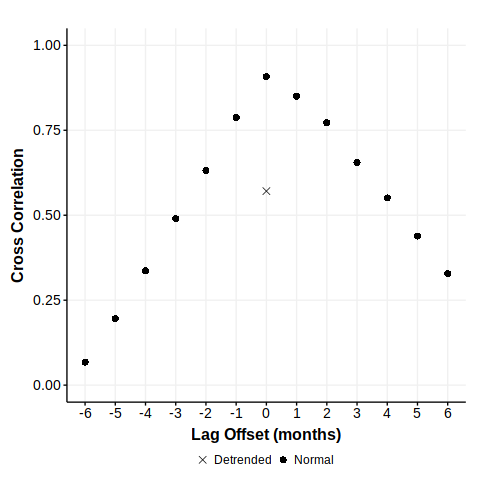

In [87]:
%%R -i trend -i lags

lags <- factor(lags, levels = unique(lags))

# Create a data frame for your original points
original_data <- data.frame(lags = lags, trend = trend, type = "Normal")

# Create a data frame for the special X point
x_point <- data.frame(lags = 0, trend = 0.57100001, type = "Detrended")

# Combine the data
combined_data <- rbind(original_data, x_point)

# Create the plot with different shapes based on type
p <- ggplot(combined_data, aes(x = lags, y = trend, shape = type)) +
    geom_point(size = 3) +  # Larger points
    scale_shape_manual(values = c(Normal = 16, Detrended = 4)) +  # 16 = dot, 4 = X
    theme_Publication() +
    xlab("Lag Offset (months)") + 
    ylab("Cross Correlation") +
    ylim(0,1) +
    theme(
        axis.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        plot.title = element_text(size = 18),
        legend.text = element_text(size = 12),
        legend.title = element_blank(),  # Remove the legend title
        legend.position = "bottom"       # Position the legend at the bottom
    )

ggsave("./figures/cross_correlation.svg", plot = p, width = 5, height = 5, dpi = 300) 
p

In [32]:
trend

array([0.06772814, 0.1958978 , 0.33625129, 0.49000203, 0.63152565,
       0.78744791, 0.90826064, 0.8502389 , 0.77194201, 0.65517094,
       0.55088841, 0.43870146, 0.32804076])

In [33]:
detrend

array([0.30908437, 0.29926835, 0.34399935, 0.41342257, 0.46272153,
       0.53153531, 0.57100001, 0.40944895, 0.13695895, 0.19426512,
       0.20149625, 0.16260724, 0.0693078 ])

In [259]:
cdc_norm_df

,Year,Month,Month_Num,heroin,nat_semi,methadone,synthetic,opioid,nat_syn_semi,month_year,year,month,month_num,resident_population,heroin_norm,nat_semi_norm,methadone_norm,synthetic_norm,opioid_norm,nat_syn_semi_norm
24,2023,January,1,11063,22786,6432,146357,161661,158632,January_2023,2023,January,1,335459736,0.000033,0.000068,0.000019,0.000436,0.000482,0.000473
25,2023,February,2,10729,22518,6468,146677,161635,158794,February_2023,2023,February,2,335661692,0.000032,0.000067,0.000019,0.000437,0.000482,0.000473
26,2023,March,3,10371,22471,6518,147684,162455,159748,March_2023,2023,March,3,335876018,0.000031,0.000067,0.000019,0.000440,0.000484,0.000476
27,2023,April,4,10086,22368,6616,149088,163691,161072,April_2023,2023,April,4,336097793,0.000030,0.000067,0.000020,0.000444,0.000487,0.000479
28,2023,May,5,9834,22278,6632,150563,164976,162453,May_2023,2023,May,5,336315484,0.000029,0.000066,0.000020,0.000448,0.000491,0.000483
29,2023,June,6,9621,22005,6648,151264,165458,163064,June_2023,2023,June,6,336552261,0.000029,0.000065,0.000020,0.000449,0.000492,0.000485
30,2023,July,7,9269,21597,6685,151293,165293,162984,July_2023,2023,July,7,336806231,0.000028,0.000064,0.000020,0.000449,0.000491,0.000484
31,2023,August,8,8956,21350,6640,151169,165033,162800,August_2023,2023,August,8,337103895,0.000027,0.000063,0.000020,0.000448,0.000490,0.000483
32,2023,September,9,8697,20881,6619,150464,164027,161854,September_2023,2023,September,9,337409418,0.000026,0.000062,0.000020,0.000446,0.000486,0.000480
33,2023,October,10,8392,20076,6518,145735,158876,156811,October_2023,2023,October,10,337703191,0.000025,0.000059,0.000019,0.000432,0.000470,0.000464


In [253]:
topic_norm_df

,group_id,_total1grams,year,month,0_unnorm,1_unnorm,2_unnorm,3_unnorm,4_unnorm,5_unnorm,...,190_norm,191_norm,192_norm,193_norm,194_norm,195_norm,196_norm,197_norm,198_norm,199_norm
0,11_2021,296582.0,2021,11,396.195905,516.427262,789.117254,502.966051,604.419506,997.740312,...,0.002730,0.003841,0.002829,0.001813,0.002301,0.001695,0.001746,0.001596,0.002983,0.002591
1,12_2021,353503.0,2021,12,459.237023,601.236702,947.575384,588.582265,696.155913,1224.249694,...,0.002687,0.003799,0.002685,0.001808,0.002277,0.001678,0.001740,0.001723,0.002974,0.002524
2,1_2022,343478.0,2022,1,439.852194,583.186252,900.443063,561.784139,644.619463,1254.497210,...,0.002863,0.003902,0.002690,0.001811,0.002268,0.001659,0.001771,0.001727,0.003062,0.002519
3,2_2022,403149.0,2022,2,511.807350,720.128870,1049.897278,668.980153,764.309476,1417.901744,...,0.002741,0.003795,0.002687,0.001805,0.002151,0.001685,0.001894,0.001698,0.002954,0.002572
4,3_2022,506916.0,2022,3,680.219411,994.292782,1444.715780,848.067988,991.612153,1648.093465,...,0.002565,0.003759,0.002733,0.001774,0.002046,0.001716,0.002078,0.001680,0.002789,0.002563
5,4_2022,561264.0,2022,4,770.944397,1130.428998,1636.034294,973.634410,1085.304838,1685.348394,...,0.002242,0.003693,0.002703,0.001809,0.001980,0.001719,0.002142,0.001659,0.002642,0.002589
6,5_2022,621793.0,2022,5,908.170867,1288.303795,1835.532192,1106.255383,1184.968041,1707.374561,...,0.001989,0.003543,0.002616,0.001880,0.001925,0.001719,0.002180,0.001726,0.002624,0.002628
7,6_2022,710526.0,2022,6,1046.186584,1476.985346,2148.324057,1296.880973,1360.454980,1877.858487,...,0.001937,0.003480,0.002597,0.001884,0.001923,0.001745,0.002190,0.001807,0.002585,0.002582
8,7_2022,813885.0,2022,7,1237.503886,1690.542260,2471.428929,1490.279899,1575.448452,2161.864627,...,0.001909,0.003472,0.002690,0.001890,0.001914,0.001754,0.002194,0.001815,0.002544,0.002606
9,8_2022,833012.0,2022,8,1275.726224,1733.768590,2522.123519,1525.158746,1617.068669,2209.832954,...,0.001907,0.003482,0.002677,0.001885,0.001915,0.001755,0.002191,0.001822,0.002538,0.002599


In [92]:
%%R 
head(cmt7_cln_lwic)

    message_id                                   message     video_id
1 6.912639e+18                Hi I really love your eyes 6.912577e+18
2 6.912664e+18 Hola btw I love your hair it's so cute 😁 6.912577e+18
3 6.912689e+18          hii 👋🏾😁 how was ur day today? 6.912577e+18
4 6.912689e+18      AAAHHHH your so pretty 🥺Heyyoooo 💙 6.912577e+18
5 6.912702e+18        Hiiii and you are sooooo beautiful 6.912577e+18
6 6.912731e+18         Ello shawty is that good or no 😏 6.912577e+18
  create_time like_count parent_comment_id reply_count month_year _intercept
1  1609474308          1      6.912577e+18           0    12_2020          1
2  1609479909          1      6.912577e+18           0     1_2021          1
3  1609485790          1      6.912577e+18           1     1_2021          1
4  1609485812          1      6.912577e+18           0     1_2021          1
5  1609488828          2      6.912577e+18           1     1_2021          1
6  1609495660          2      6.912577e+18           0 

In [55]:
a = %sql SHOW TABLES
print(a)

Running query in 'mysql://iasamori@localhost/?charset=utf8mb4'

17 rows affected.

+--------------------------------------------------------+
|                   Tables_in_iasamori                   |
+--------------------------------------------------------+
|                          cmt7                          |
|                        cmt7_cln                        |
|              cmt7_cln_lda$tpc7_200_a2s100              |
|                     cmt7_cln_lwic                      |
|                        cmt7_en                         |
|                     cmt7_en_dedup                      |
|             feat$1gram$cmt7_cln$message_id             |
|         feat$1gram$cmt7_cln$message_id$0_0001          |
|             feat$1gram$cmt7_cln$month_year             |
|          feat$1gram$cmt7_en_dedup$message_id           |
|      feat$cat_LIWC2015_w$cmt7_cln$message_id$1gra      |
| feat$cat_tpc7_200_a2s100_cp_w$cmt7_cln$message_id$1gra |
|          feat$meta_1gram$cmt7_cln$message_id           |
|          feat$meta_1gram$cmt7_cln$month_year          